# No Reference Metrics

Demonstrate the use of the no-reference metrics: noise power spectrum (NPS), modulation transfer function (MTF), and noise equivalent quanta (NEQ).

In [1]:
from xdesign import *
import tomopy
import numpy as np
import matplotlib.pylab as plt

Generate a UnitCircle test phantom. For the MTF, the radius must be less than 0.5, otherwise the circle touches the edges of the field of view.

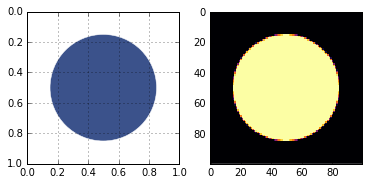

In [2]:
p = UnitCircle(radius=0.35)
sidebyside(p, 100)
plt.show()

Generate two sinograms and reconstruct. Noise power spectrum and Noise Equivalent Quanta are meaningless withouth noise so add some poisson noise to the reconstruction process with the `noise` argument. Collecting two sinograms allows us to isolate the noise by subtracting out the circle.

In [3]:
np.random.seed(0)
sinoA, prbA = sinogram(100, 100, p, noise=0.01)
sinoB, prbB = sinogram(100, 100, p, noise=0.01)
theta = np.arange(0, np.pi, np.pi / 100.)

sinoB = -np.log(sinoB)/prbB.size
sinoA = -np.log(sinoA)/prbA.size

recA = tomopy.recon(np.expand_dims(sinoA, 1), theta, algorithm='gridrec', center=(sinoA.shape[1]-1)/2.)
recB = tomopy.recon(np.expand_dims(sinoB, 1), theta, algorithm='gridrec', center=(sinoB.shape[1]-1)/2.)

Take a look at the two noisy reconstructions.

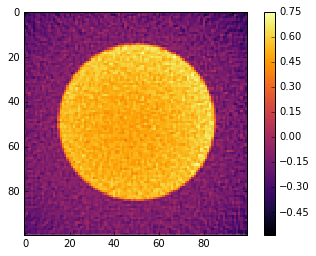

In [4]:
plt.imshow(recA[0], cmap='inferno', interpolation="none")
plt.colorbar()
plt.savefig('UnitCircle_noise0.png', dpi=600,
        orientation='landscape', papertype=None, format=None,
        transparent=True, bbox_inches='tight', pad_inches=0.0,
        frameon=False)
plt.show()

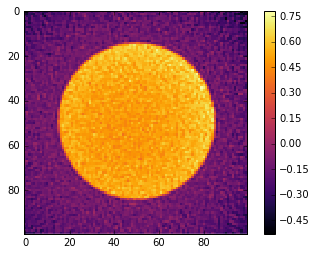

In [5]:
plt.imshow(recB[0], cmap='inferno', interpolation="none")
plt.colorbar()
plt.show()

# Calculate MTF
Use Friedman et al's method for computing the MTF. You can separate the MTF into multiple directions or average them all together using the `Ntheta` argument.

In [6]:
mtf_freq, mtf_value, labels = compute_mtf_ffst(p, recA[0], Ntheta=4)

The MTF is really a symmetric function around zero frequency, so usually people just show the positive portion. Sometimes, there is a peak at the higher spatial frequencies instead of the MTF approaching zero. This is probably because of aliasing noise content with frequencies higher than the Nyquist frequency. 

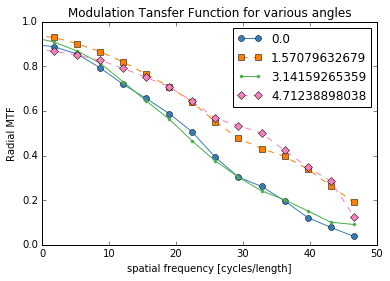

In [7]:
plot_mtf(mtf_freq, mtf_value, labels)
plt.gca().set_xlim([0,50]) # hide negative portion of MTF
plt.show()

You can also use a Siemens Star to calculate the MTF using a fitted sinusoidal method instead of the slanted edges that the above method uses.

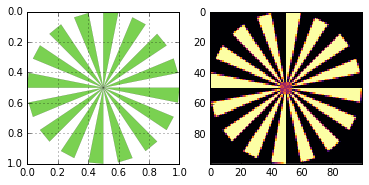

In [8]:
s = SiemensStar(n_sectors=32, center=Point([0.5, 0.5]), radius=0.5)
d = sidebyside(s, 100)
plt.show()

Here we are using the discreet verison of the phantom (without noise), so we are only limited by the resolution of the image.

In [9]:
mtf_freq, mtf_value = compute_mtf_lwkj(s, d)

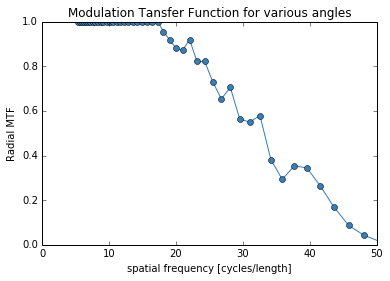

In [10]:
plot_mtf(mtf_freq, mtf_value, labels=None)
plt.gca().set_xlim([0,50]) # hide portion of MTF beyond Nyquist frequency
plt.show()

# Calculate NPS

Calculate the radial or 2D frequency plot of the NPS.

In [11]:
X, Y, NPS = compute_nps_ffst(p, recA[0], plot_type='frequency',B=recB[0])

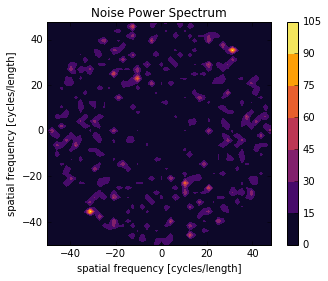

In [12]:
plot_nps(X, Y, NPS)
plt.show()

In [13]:
bins, counts = compute_nps_ffst(p, recA[0], plot_type='histogram',B=recB[0])

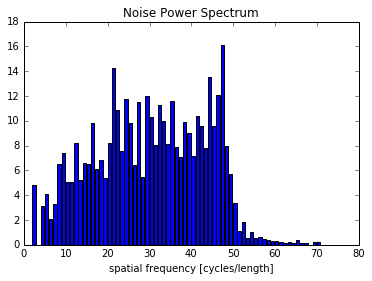

In [14]:
plt.figure()
plt.bar(bins, counts)
plt.xlabel('spatial frequency [cycles/length]')
plt.title('Noise Power Spectrum')
plt.show()

# Calculate NEQ

In [15]:
freq, NEQ = compute_neq_d(p, recA[0], recB[0])

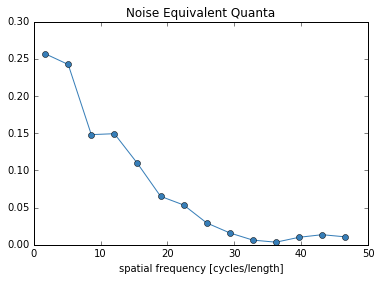

In [16]:
plt.figure()
plt.plot(freq.flatten(), NEQ.flatten())
plt.xlabel('spatial frequency [cycles/length]')
plt.title('Noise Equivalent Quanta')
plt.show()